In [1]:
import time
import numpy as np
from scipy.integrate  import quad
import scipy.stats as ss
from scipy.stats import gaussian_kde, norm
from astropy.cosmology import Planck15 as cosmo

import models, gnobs, conversions
import parameter_estimation as pe

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pycbc.psd

from pycbc.catalog import Merger
#from pycbc.types import FrequencySeries
from gwpy.frequencyseries import FrequencySeries

from pycbc.filter import match
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import sigmasq, match, matched_filter, resample_to_delta_t, highpass

from gwpy.timeseries import TimeSeries
from pycbc import types
from pycbc import frame
from importlib import reload

In [2]:
params = {'font.family': 'serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)

In [3]:
gps = {'GW190814':1249852257.009818187, 'S190925ac':1253466644.45, 'GW190924':1253}
mchirp = {'GW190814':6.386, 'S190925ac':8.33, 'GW190924':6.44, 'S200210ba':7.63}
template_param = {'GW190814':[20.84, 3.04, -0.22075345, 0.38675523], 'S190925ac':[25.421, 4.079, -0.422, 0.261]}

In [4]:
reload(pe)

<module 'parameter_estimation' from '/nfshome/store04/users/vaibhav.tiwari/O4/varaha_HM/parameter_estimation.py'>

In [5]:
obs = 'GW190814'
if obs == 'GW190814':
    net = ['L1', 'H1', 'V1']
if obs == 'S190925ac':
    net = ['L1', 'H1']
    
f_low, f_final = 20., 1024
freqs = np.array([20., f_final])
m1, m2, s1z, s2z = template_param[obs]

In [6]:
reload(pe)

<module 'parameter_estimation' from '/nfshome/store04/users/vaibhav.tiwari/O4/varaha_HM/parameter_estimation.py'>

In [7]:
segl = pe.get_length_for_flow(template_param[obs], f_low)

In [8]:
strain = {}
gps_start, gps_stop = gps[obs] - segl, gps[obs] + segl
for det in net:
    if det != 'V1':
        strain[det] = TimeSeries.get(det + ':GDS-CALIB_STRAIN_CLEAN', gps_start, gps_stop, frametype= det + '_HOFT_C01', verbose=True)
        strain[det] = strain[det].to_pycbc()
    else:
        strain[det] = TimeSeries.get('V1:Hrec_hoft_16384Hz_Gated', gps_start, gps_stop, frametype = 'V1Online', verbose=True)
        strain[det] = strain[det].astype(np.float64).to_pycbc()
    print (freqs[-1])

Attempting to access data from frames...
Reading L1_HOFT_C01 frames: |██████████| 1/1 (100%) ETA 00:00 

no Fr{Adc,Proc,Sim}Data structures with the name L1:GDS-CALIB_STRAIN_CLEAN


Failed to access data from frames, trying NDS...
Reading L1_HOFT_C01 frames: |██████████| 1/1 (100%) ETA 00:00 
Opening new connection to nds.ligo.caltech.edu... connected
    [nds.ligo.caltech.edu] set ALLOW_DATA_ON_TAPE='False'
Checking channels list against NDS2 database... done
1024.0
Attempting to access data from frames...
Reading H1_HOFT_C01 frames: |██████████| 1/1 (100%) ETA 00:00 

no Fr{Adc,Proc,Sim}Data structures with the name H1:GDS-CALIB_STRAIN_CLEAN


Failed to access data from frames, trying NDS...
Reading H1_HOFT_C01 frames: |██████████| 1/1 (100%) ETA 00:00 
Opening new connection to nds.ligo.caltech.edu... connected
    [nds.ligo.caltech.edu] set ALLOW_DATA_ON_TAPE='False'
Checking channels list against NDS2 database... done
1024.0
Attempting to access data from frames...
Reading V1Online frames: |██████████| 1/1 (100%) ETA 00:00 
1024.0


In [9]:
psd, df = {}, strain[det].delta_f
for det in net:
    fname = '/nfshome/store04/users/vaibhav.tiwari/scripts/rates_related/observational_data/psds/' + obs + '/' + det + '_psd.dat'
    psd[det] = pycbc.psd.from_txt(fname, int(f_final/df) + 1, delta_f = df, low_freq_cutoff = 10., is_asd_file=False)
    psd[det][:int(10/df)] = psd[det][int(10/df) + 1]

In [10]:
ts = {}
ndownsample = len(psd[det])
for det in net:
    sptilde = strain[det].to_frequencyseries()
    sptilde.resize(ndownsample)
    sptilde /= psd[det]
    ts[det] = sptilde.to_timeseries()

In [11]:
reload(pe)

<module 'parameter_estimation' from '/nfshome/store04/users/vaibhav.tiwari/O4/varaha_HM/parameter_estimation.py'>

In [12]:
segments = [gps[obs] - 4 * segl/5, gps[obs] + segl / 5]
ts_ft, psd = pe.prepare_strain_data(segments, ts, gps, psd)

In [13]:
print (det, len(ts_ft[det]), 1./ts_ft[det].delta_f, ts_ft[det].sample_frequencies[-1])
print ()
print (det, len(psd[det]), 1./psd[det].delta_f, psd[det].sample_frequencies[-1])

V1 32769 32.0 1024.0

V1 32769 32.0 1024.0


Text(0.5, 0.98, 'psd')

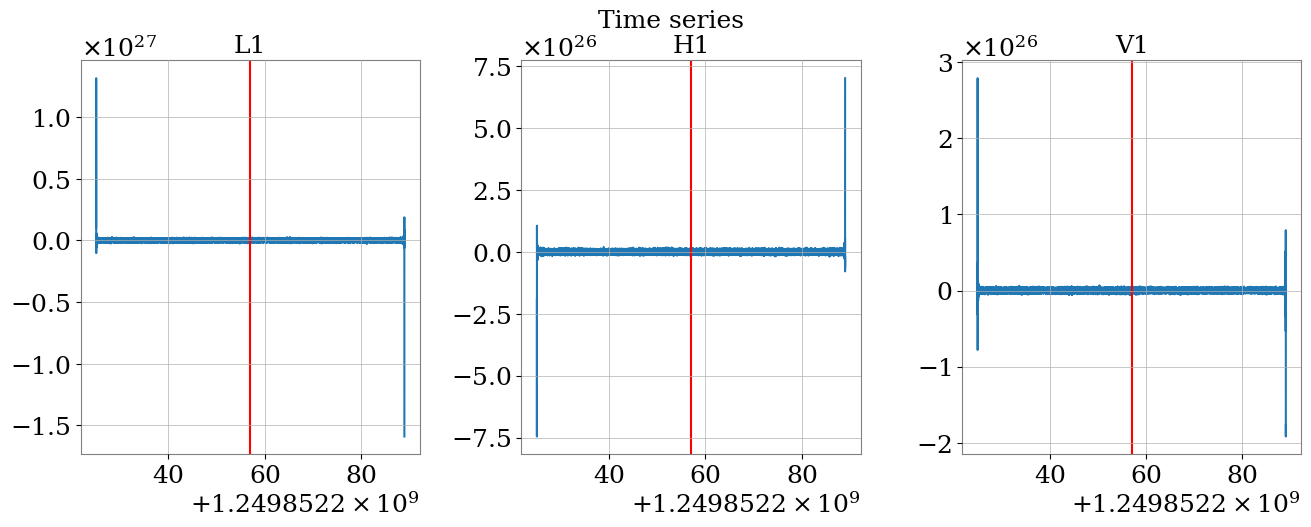

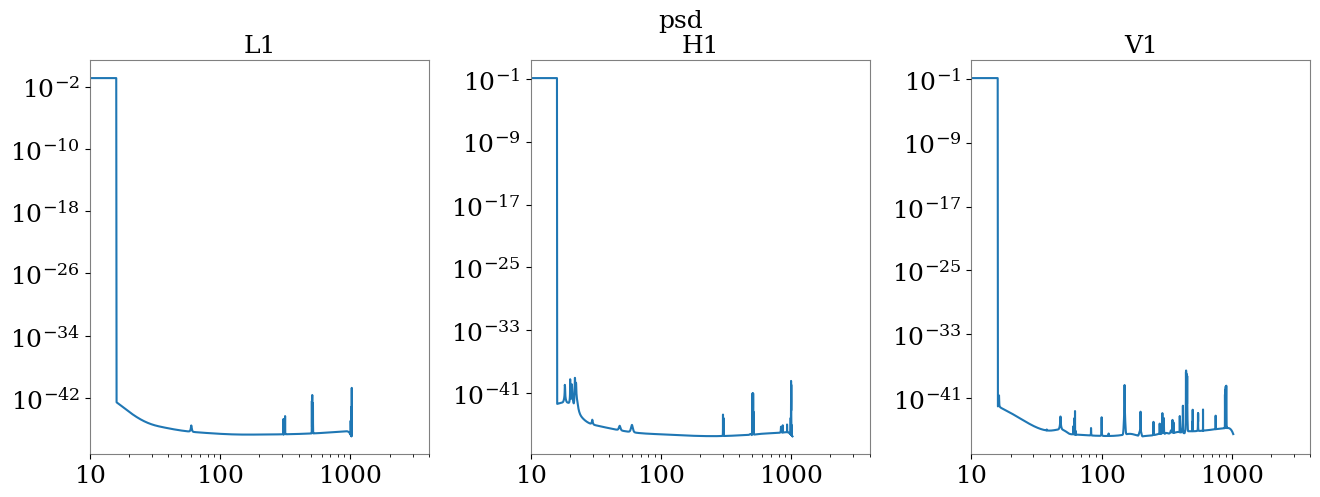

In [14]:
fig, ax = plt.subplots(1,3,figsize = figsize)
for det in net:
    i = net.index(det)
    
    t = ts[det].sample_times
    
    ax[i].plot(t,ts[det])
    ax[i].set(title = det)
    ax[i].axvline(gps[obs], color = 'r')
plt.subplots_adjust(wspace =0.3)
fig.suptitle('Time series')

fig1, ax1 = plt.subplots(1,len(net),figsize = figsize)
for det in net:
    i = net.index(det)
    ax1[i].plot(psd[det].sample_frequencies,psd[det])
    ax1[i].set(title = det)
    ax1[i].set_yscale('log')
    ax1[i].set_xscale('log')
    ax1[i].set_xlim(10,4*1e3)
    ax1[i].grid()

plt.subplots_adjust(wspace =0.3)
fig1.suptitle('psd')
#fig1.savefig('./psd_'+str(time['H1'])+'sec.png', dpi=600)

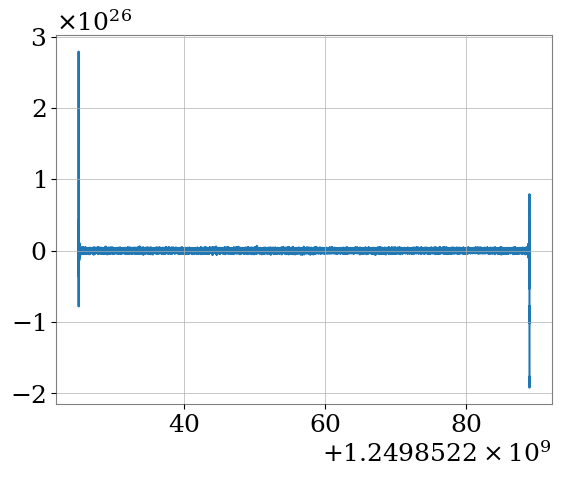

In [15]:
plt.plot(ts[det].sample_times,ts[det])

### Perform L1H1 PE

In [18]:
reload(pe)

<module 'parameter_estimation' from '/nfshome/store04/users/vaibhav.tiwari/O4/varaha_HM/parameter_estimation.py'>

In [ ]:
#Perform PE -- takes a long time -- very poor performance on head node
t0 = time.time()
yy = pe.sample_full_pe(ts_ft, psd, gps[obs], template_param[obs], freqs, 5)
print (time.time() - t0)

0 [4 5 5 4 7 4] 8000 2.3 281.27 216.98 0.0
1 [7 7 8 7 7 5] 8000 13.7 283.08 250.19 0.0
2 [12  7 11 10  7 10] 8000 92.5 283.8 264.19 0.0
3 [14 11 15 11 13 13] 11322 579.3 284.54 274.42 0.001
4 [15 14 15 14 13 14] 39560 2166.5 284.68 274.42 0.001
5 [19 14 18 16 10 14] 70689 3917.7 284.68 274.42 0.001
6 [19 13 19 17 12 14] 110193 6076.2 284.68 274.42 0.001
7 [19 13 21 18 13 13] 152950 8384.9 284.71 274.42 0.001
0 ) [20.84    3.04   -0.2208  0.3868]
Nbins: [ 4  9 11 13]
max dpsi 17.835363223720172
4.83 290.47 285.62 206.12 1000 0.0

1 ) [20.84    3.04   -0.2208  0.3868]
Nbins: [ 8 12 12  9]
max dpsi 15.540935623751746
6.35 290.47 285.62 231.3 1000 0.0

2 ) [20.84    3.04   -0.2208  0.3868]
Nbins: [10 16 13 10]
max dpsi 8.277114989108693
9.64 290.47 285.62 252.43 1000 0.0

3 ) [20.84    3.04   -0.2208  0.3868]
Nbins: [11 21 14 13]
max dpsi 7.373199381485074
19.33 290.47 285.62 264.92 1000 0.0

4 ) [20.84    3.04   -0.2208  0.3868]
Nbins: [13 24 18 15]
max dpsi 7.098879976440488
42.45 290.47

In [21]:
extrinsic_mc, args_extrin, params_extrin, intrinsic_mc, args_intrin, params_intrin, t0 = yy
lkl_thr = args_intrin['lkl_thr']

full_pe = pe.collect_posterior(extrinsic_mc, intrinsic_mc, lkl_thr)
lkl = full_pe['log_likelihood']
prob = np.exp(lkl - np.max(lkl))
mchirp_mc = full_pe['mchirp']
q_mc = full_pe['q']
s1z_mc = full_pe['spin1z']
s2z_mc = full_pe['spin2z']
lumd_mc = full_pe['lumd']
z_mc = conversions.dlum_to_z(lumd_mc)
mchirp_src_mc = mchirp_mc / (1 + z_mc)
m1_mc, m2_mc = conversions.qmch_to_m1m2(mchirp_mc, q_mc)
m1_src_mc, m2_src_mc = conversions.qmch_to_m1m2(mchirp_src_mc, q_mc)

Text(0.5, 0, 'Luminosity Distance (Mpc)')

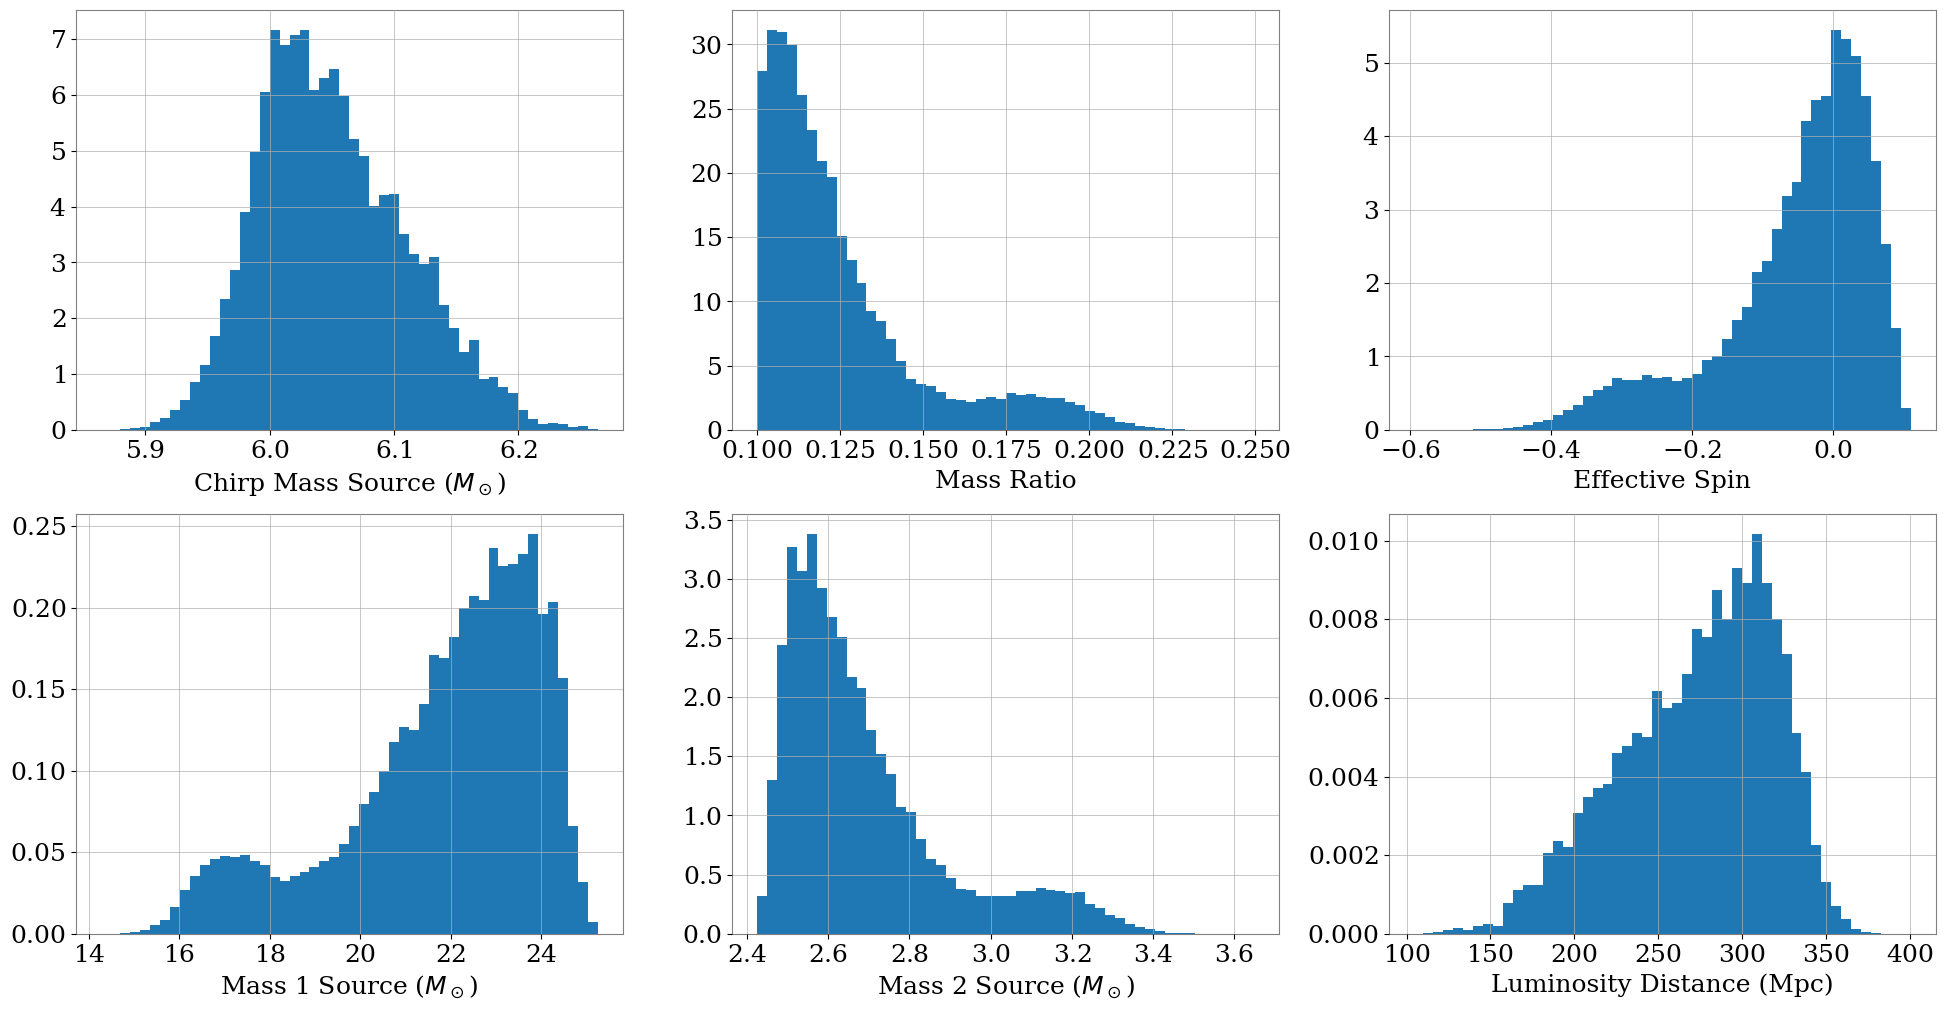

In [24]:
chieff_mc = (s1z_mc + q_mc * s2z_mc) / (1 + q_mc)
fig = plt.figure(figsize = (24.0, 12.0))
plt.subplot(2, 3, 1)
xx = plt.hist(mchirp_src_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Chirp Mass Source ($M_\odot$)')
plt.subplot(2, 3, 2)
xx = plt.hist(q_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Mass Ratio')
plt.subplot(2, 3, 3)
xx = plt.hist(chieff_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Effective Spin')
plt.subplot(2, 3, 4)
xx = plt.hist(m1_src_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Mass 1 Source ($M_\odot$)')
plt.subplot(2, 3, 5)
xx = plt.hist(m2_src_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Mass 2 Source ($M_\odot$)')
plt.subplot(2, 3, 6)
xx = plt.hist(lumd_mc, weights = prob, density = True, bins = 50)
plt.xlabel('Luminosity Distance (Mpc)')

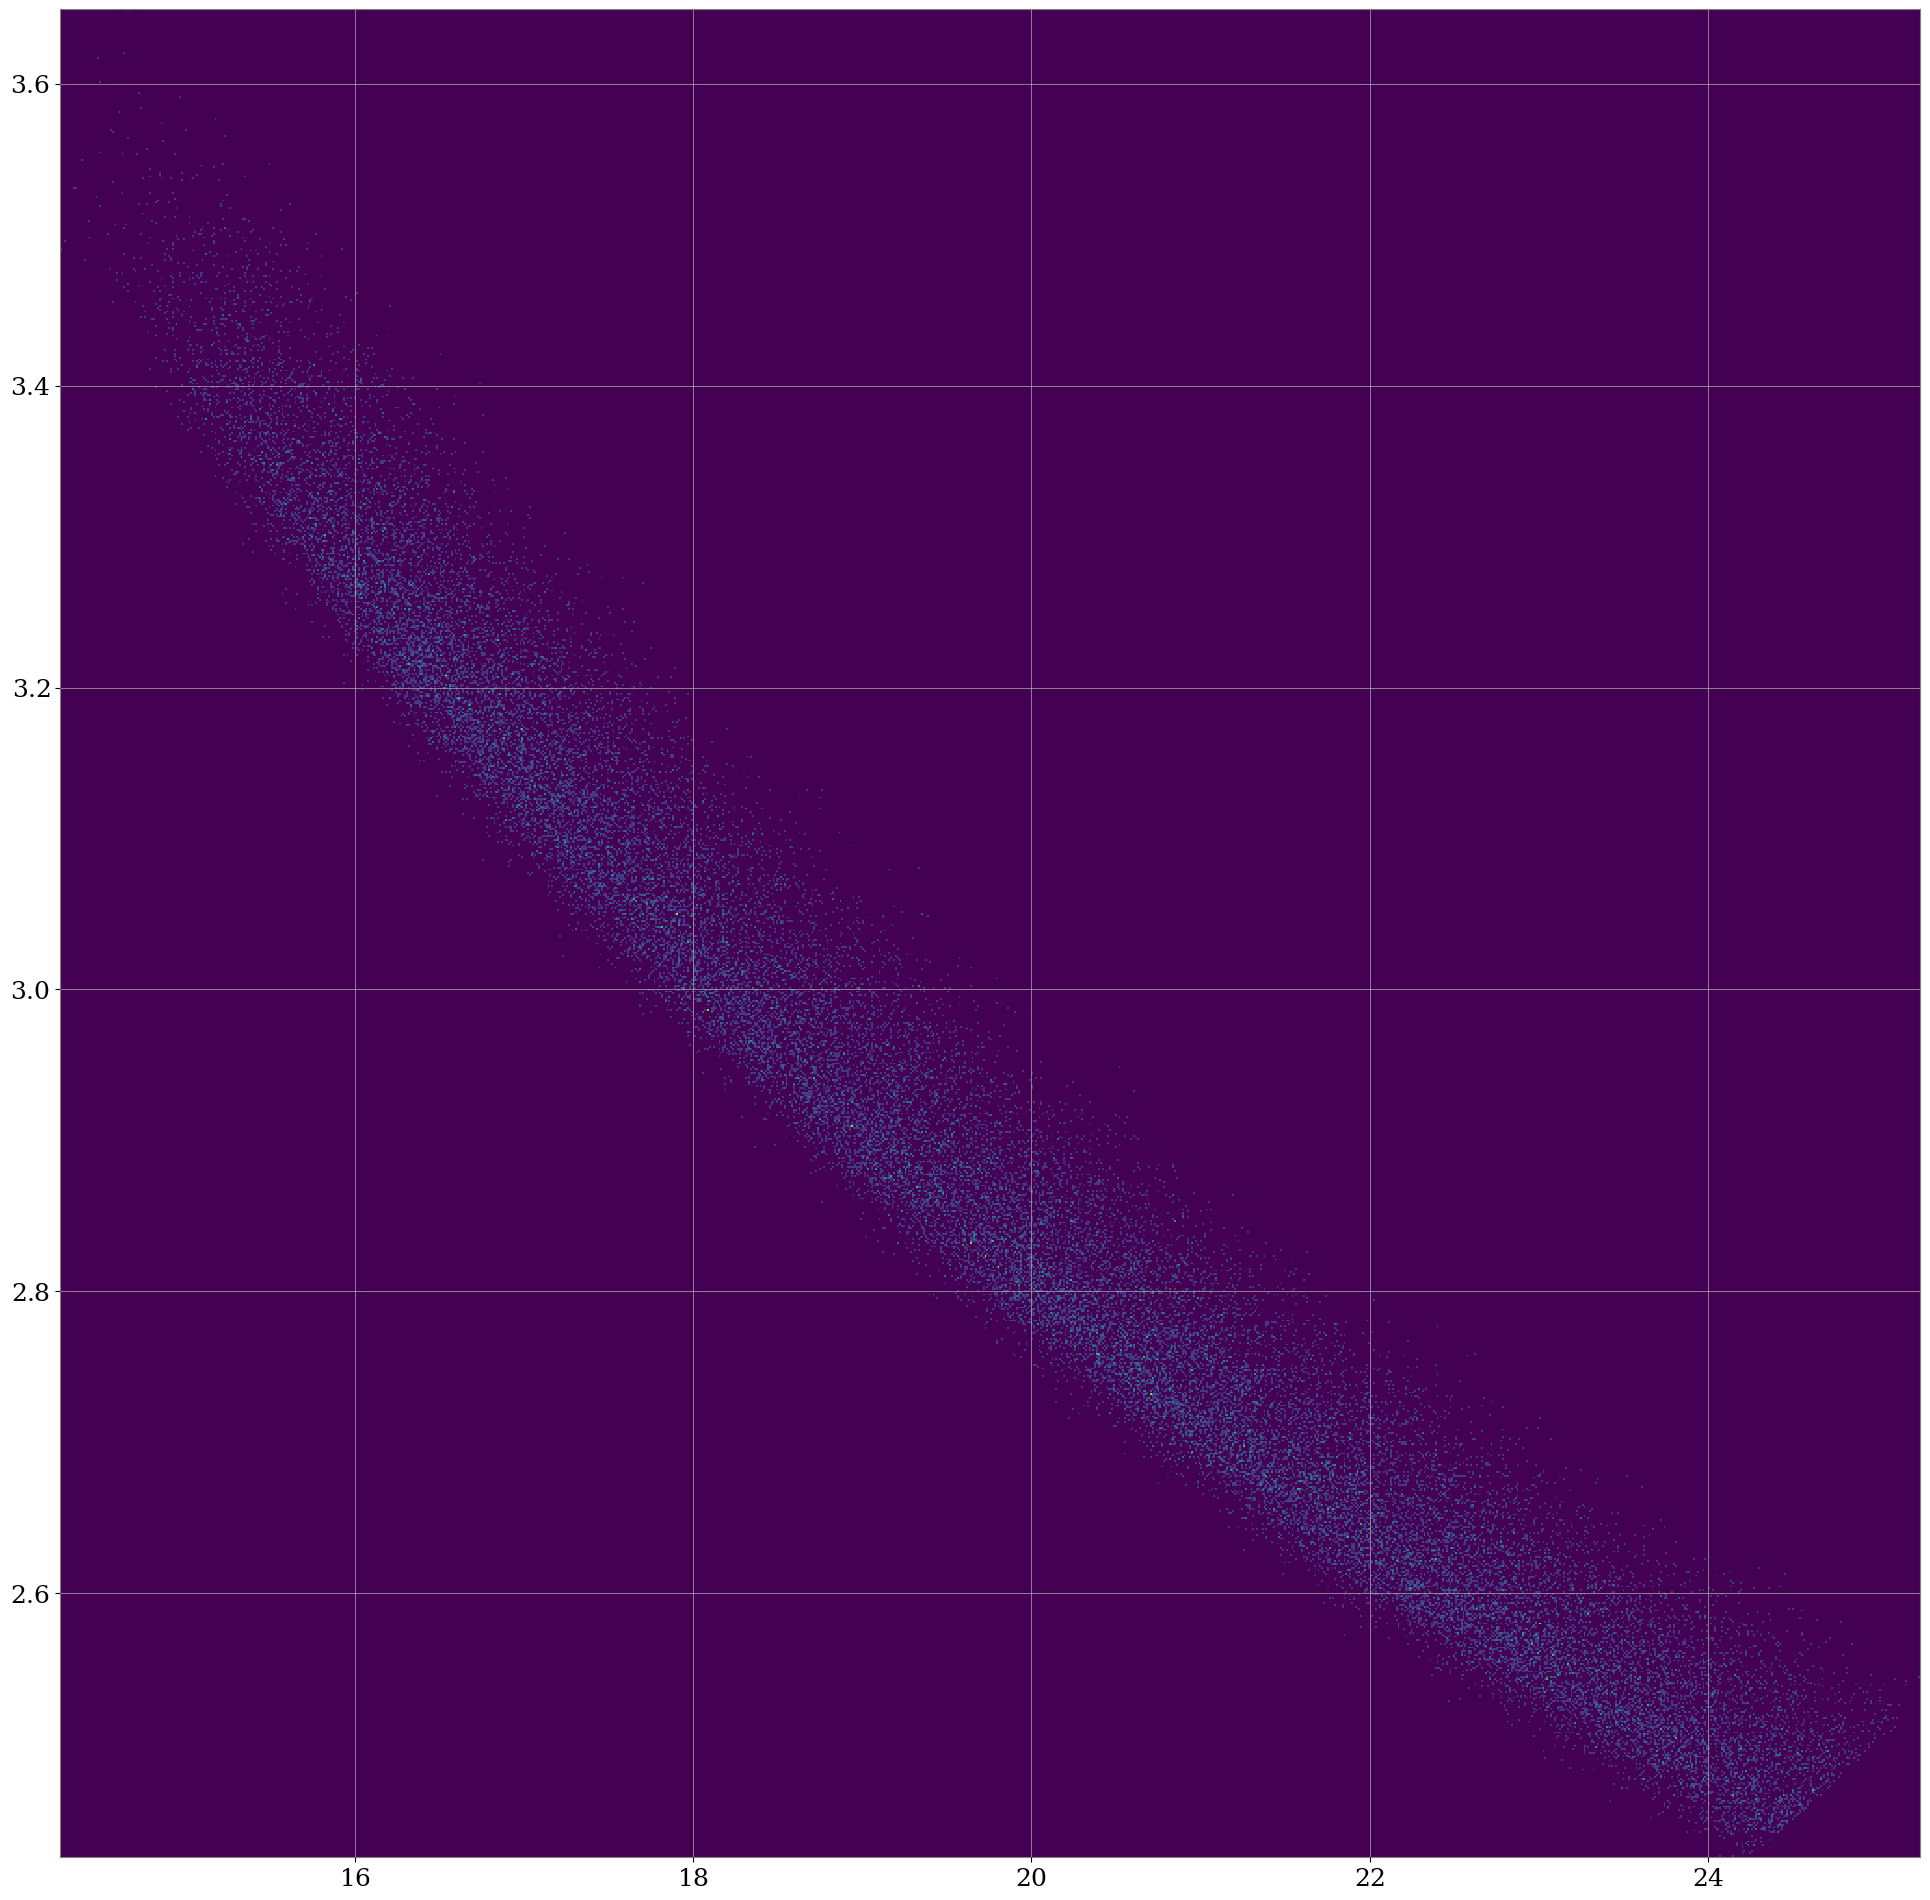

In [25]:
fig = plt.figure(figsize = (24.0, 24.0))
xx = plt.hist2d(m1_src_mc, m2_src_mc, density = True, bins = 1000)

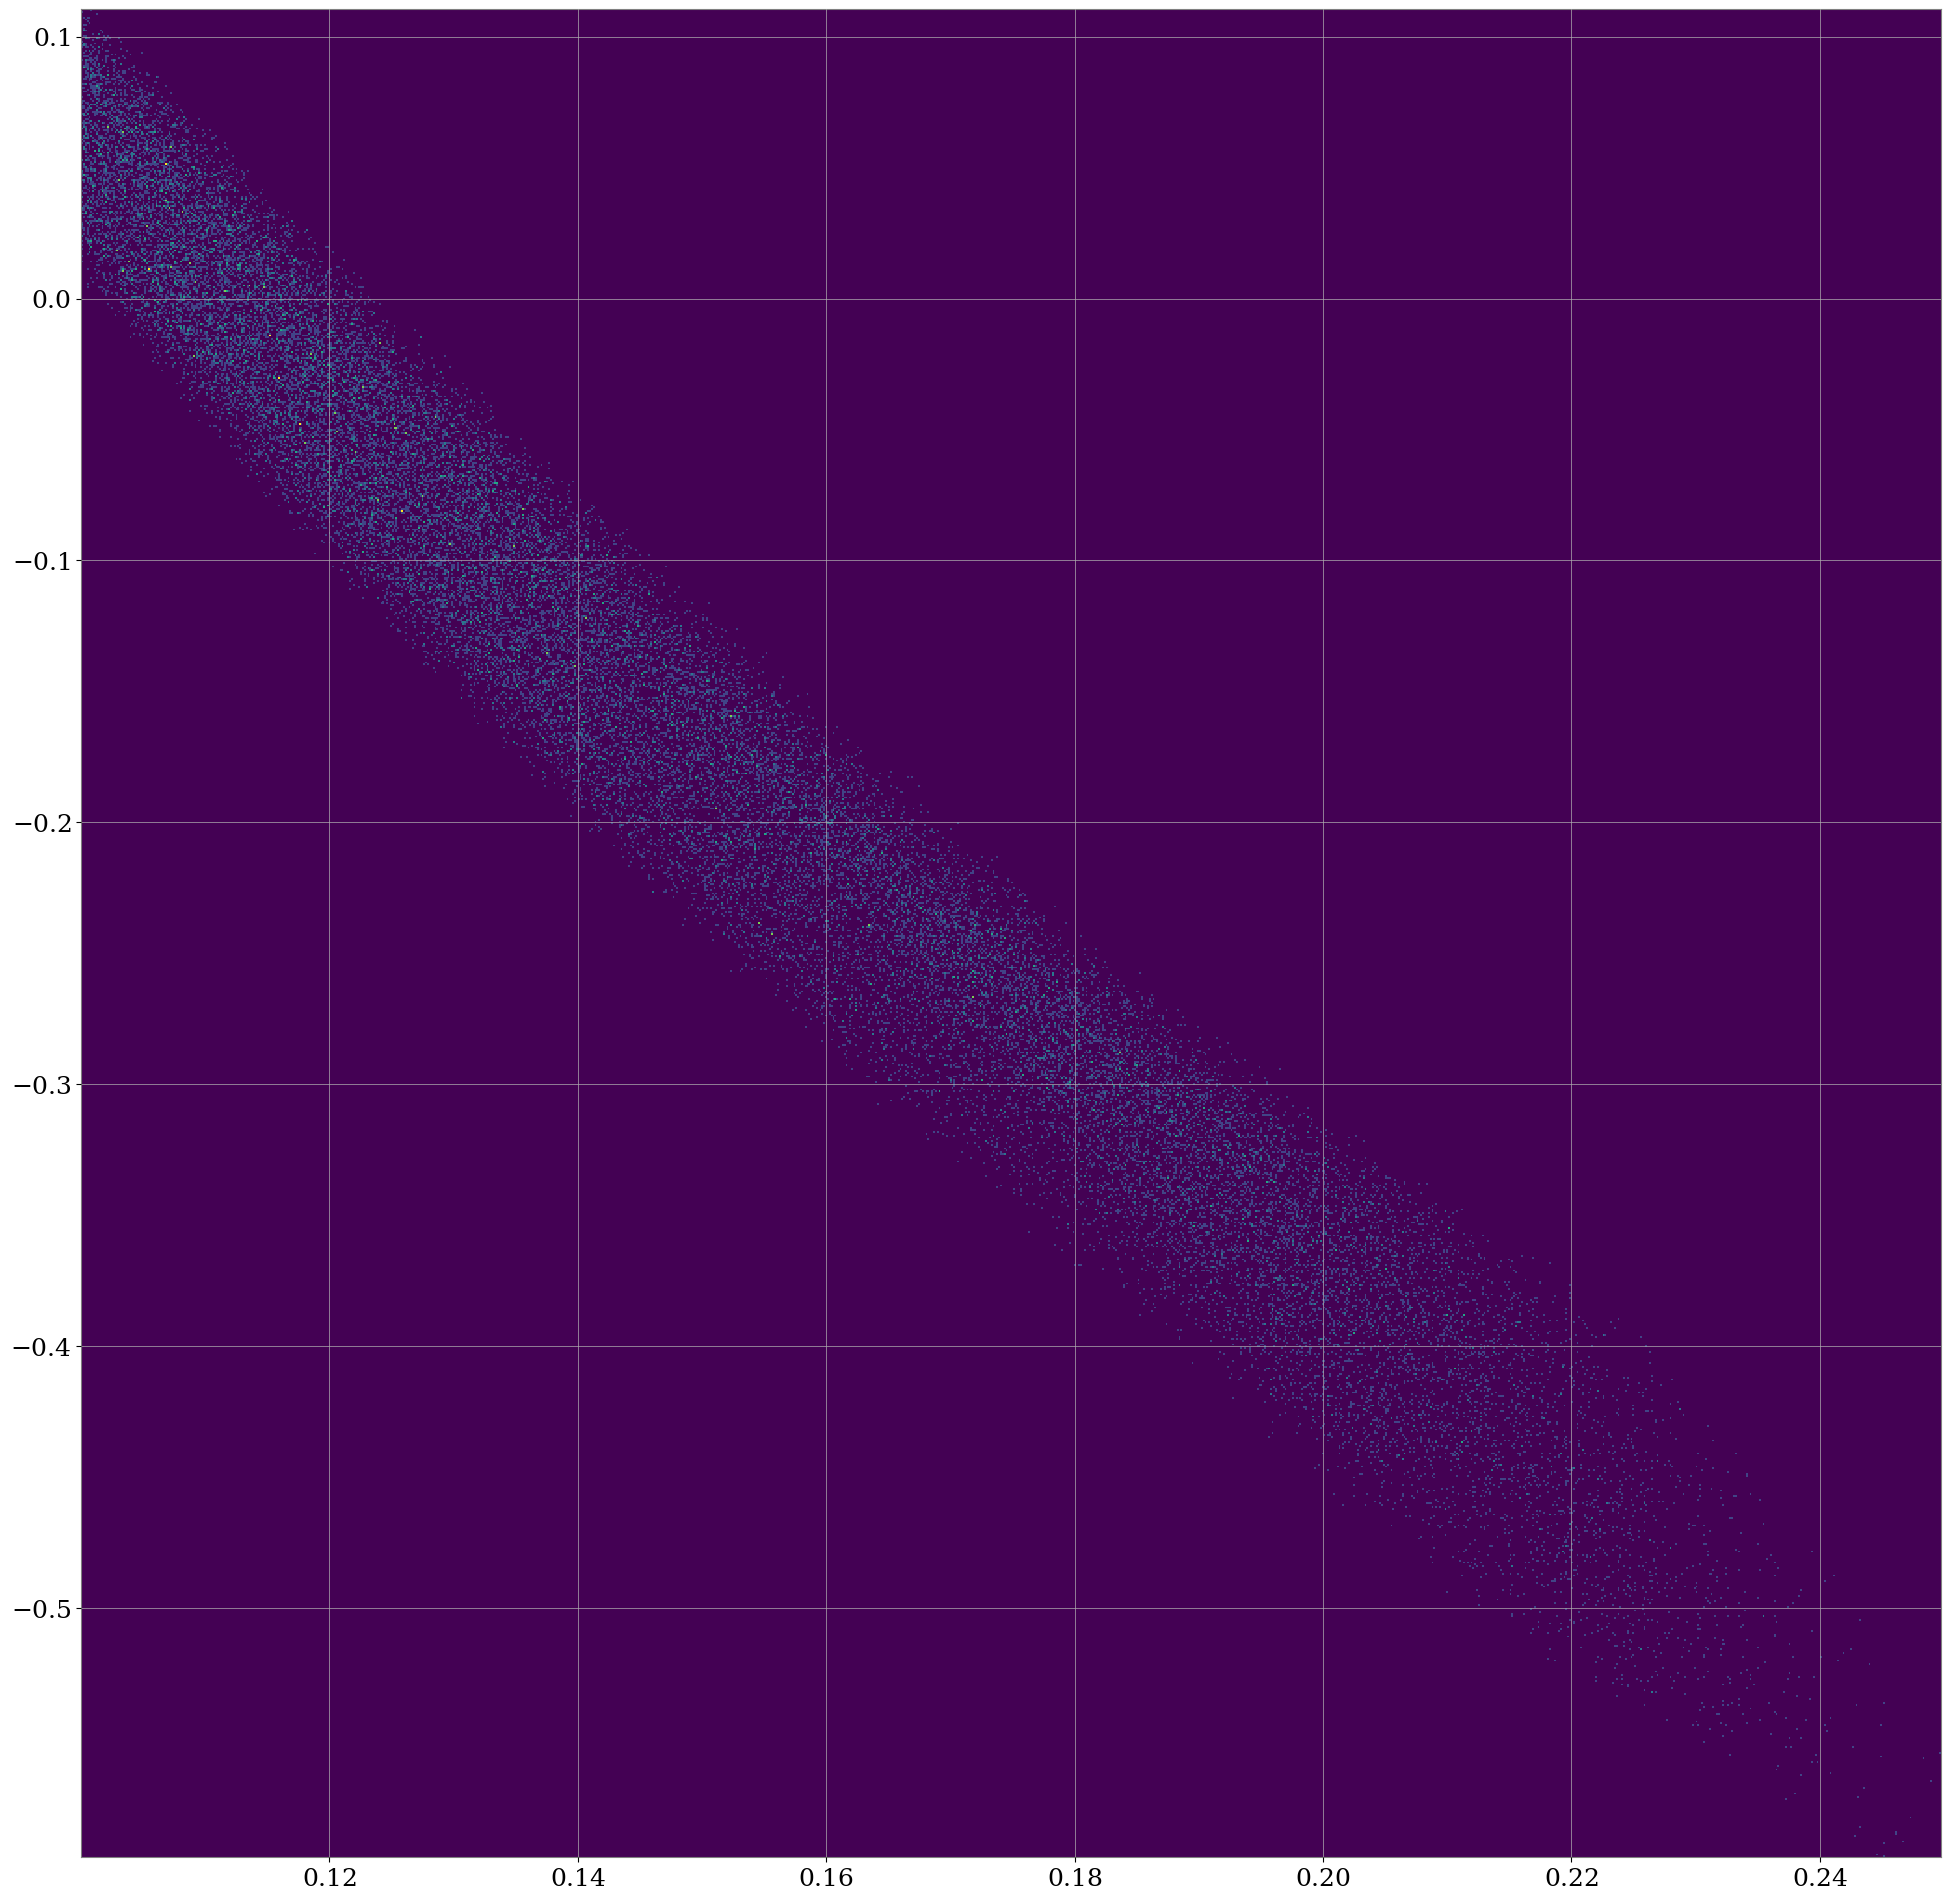

In [26]:
fig = plt.figure(figsize = (24.0, 24.0))
xx = plt.hist2d(q_mc, chieff_mc, density = True, bins = 1000)

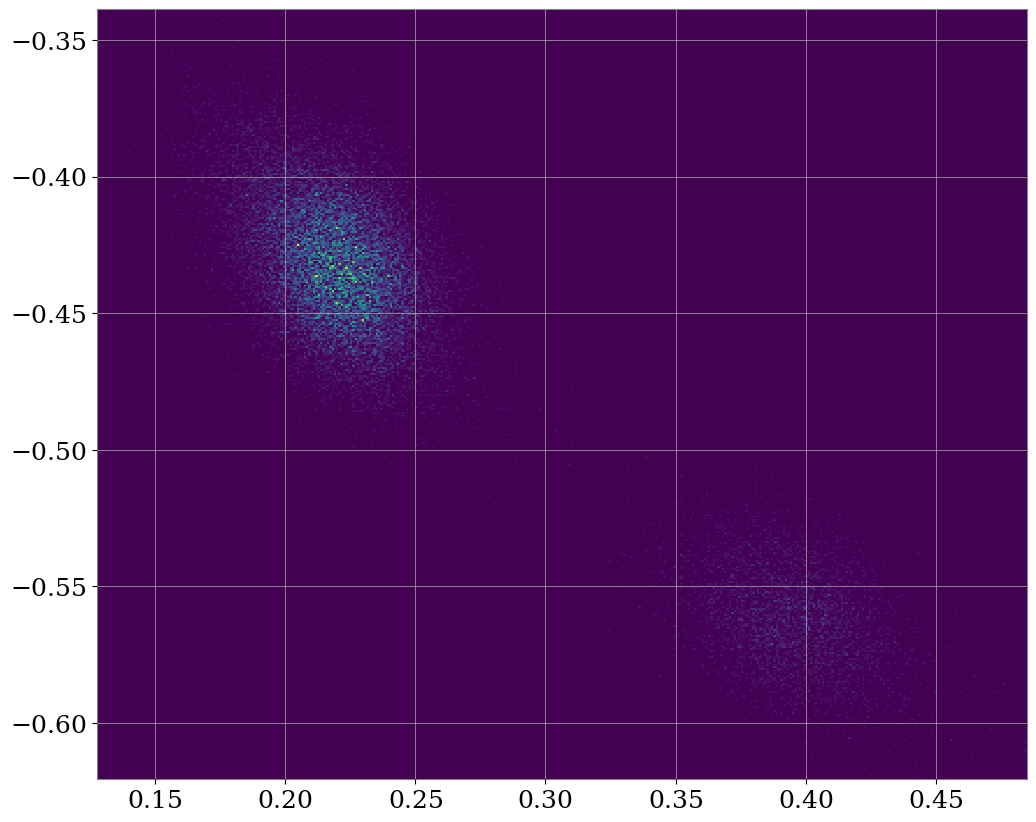

In [27]:
fig = plt.figure(figsize = (12.0, 10.0))
xx = plt.hist2d(full_pe['ra'], full_pe['dec'], density = True, bins = 400)

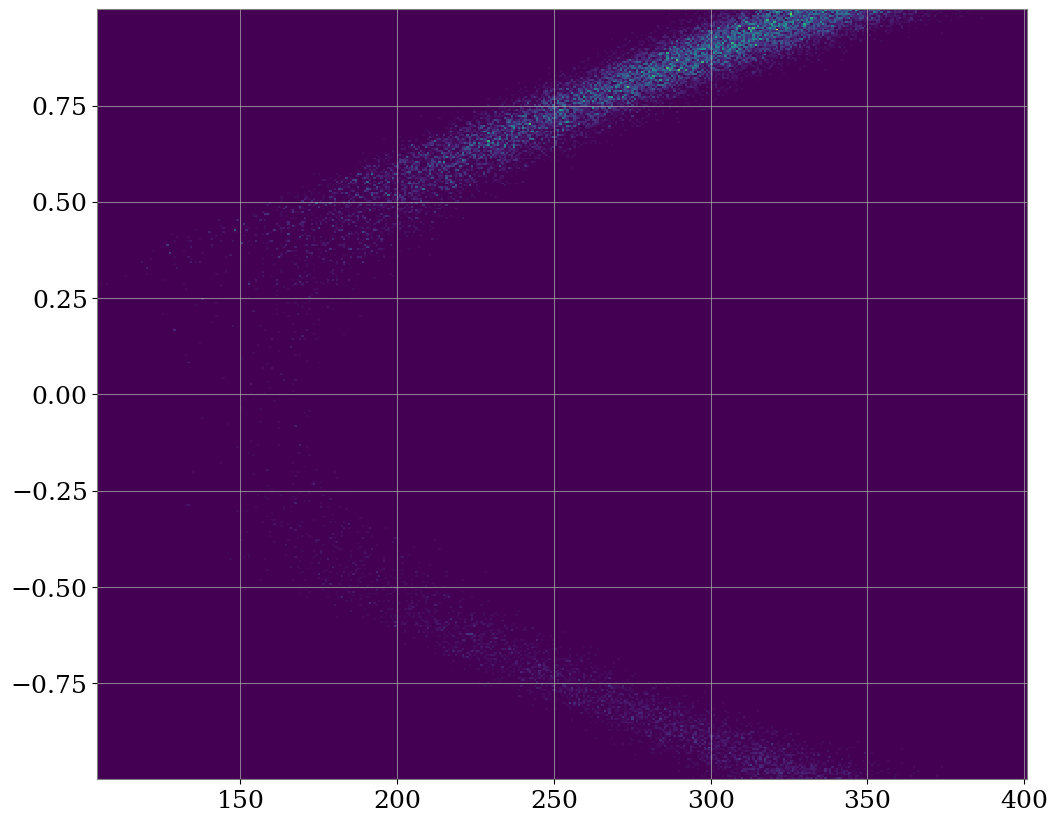

In [28]:
fig = plt.figure(figsize = (12.0, 10.0))
xx = plt.hist2d(full_pe['lumd'], full_pe['cosi'], density = True, bins = 400)

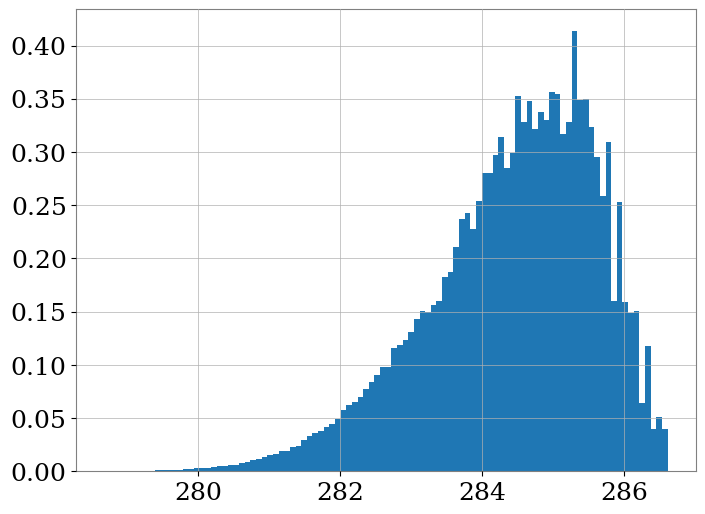

In [29]:
lkl = full_pe['log_likelihood']
prob = np.exp(lkl - np.max(lkl))
fig = plt.figure(figsize = (8.0, 6.0))
xx = plt.hist(lkl, weights = prob, density = True, bins = 100)